(basic-demo)=
# Feature store example (stocks)

This notebook demonstrates the following:
- Generate features and feature-sets
- Build complex transformations and ingest to offline and real-time data stores
- Fetch feature vectors for training
- Save feature vectors for re-use in real-time pipelines
- Access features and their statistics in real-time

```{admonition} Note
By default, this demo works with the online feature store, which is currently not part of the Open Source MLRun default deployment.
```

**In this section**
- [Get started](#get-started)
- [Create sample data for demo](#create-sample-data-for-demo)
- [Define, infer and ingest feature sets](#define-infer-and-ingest-feature-sets)
- [Get an offline feature vector for training](#get-an-offline-feature-vector-for-training)
- [Initialize an online feature service and use it for real-time inference](#initialize-an-online-feature-service-and-use-it-for-real-time-inference)

## Get started

Install the latest MLRun package and restart the notebook.

Setting up the environment and project:

In [1]:
import mlrun
mlrun.set_environment(project="stocks")

> 2021-05-23 09:04:04,507 [warning] Failed resolving version info. Ignoring and using defaults
> 2021-05-23 09:04:07,033 [warning] Unable to parse server or client version. Assuming compatible: {'server_version': '0.6.4-rc3', 'client_version': 'unstable'}


('stocks', 'v3io:///projects/{{run.project}}/artifacts')

## Create sample data for demo

In [2]:
import pandas as pd
quotes = pd.DataFrame(
    {
        "time": [
            pd.Timestamp("2016-05-25 13:30:00.023"),
            pd.Timestamp("2016-05-25 13:30:00.023"),
            pd.Timestamp("2016-05-25 13:30:00.030"),
            pd.Timestamp("2016-05-25 13:30:00.041"),
            pd.Timestamp("2016-05-25 13:30:00.048"),
            pd.Timestamp("2016-05-25 13:30:00.049"),
            pd.Timestamp("2016-05-25 13:30:00.072"),
            pd.Timestamp("2016-05-25 13:30:00.075")
        ],
        "ticker": [
               "GOOG",
               "MSFT",
               "MSFT",
               "MSFT",
               "GOOG",
               "AAPL",
               "GOOG",
               "MSFT"
           ],
           "bid": [720.50, 51.95, 51.97, 51.99, 720.50, 97.99, 720.50, 52.01],
           "ask": [720.93, 51.96, 51.98, 52.00, 720.93, 98.01, 720.88, 52.03]
    }
)

trades = pd.DataFrame(
       {
           "time": [
               pd.Timestamp("2016-05-25 13:30:00.023"),
               pd.Timestamp("2016-05-25 13:30:00.038"),
               pd.Timestamp("2016-05-25 13:30:00.048"),
               pd.Timestamp("2016-05-25 13:30:00.048"),
               pd.Timestamp("2016-05-25 13:30:00.048")
           ],
           "ticker": ["MSFT", "MSFT", "GOOG", "GOOG", "AAPL"],
           "price": [51.95, 51.95, 720.77, 720.92, 98.0],
           "quantity": [75, 155, 100, 100, 100]
       }
)


stocks = pd.DataFrame(
       {
           "ticker": ["MSFT", "GOOG", "AAPL"],
           "name": ["Microsoft Corporation", "Alphabet Inc", "Apple Inc"],
           "exchange": ["NASDAQ", "NASDAQ", "NASDAQ"]
       }
)

import datetime
def move_date(df, col):
    max_date = df[col].max()
    now_date = datetime.datetime.now()
    delta = now_date - max_date 
    df[col] = df[col] + delta 
    return df

quotes = move_date(quotes, "time")
trades = move_date(trades, "time")

### View the demo data

In [3]:
quotes

time ticker     bid     ask
0 2021-05-23 09:04:07.013574   GOOG  720.50  720.93
1 2021-05-23 09:04:07.013574   MSFT   51.95   51.96
2 2021-05-23 09:04:07.020574   MSFT   51.97   51.98
3 2021-05-23 09:04:07.031574   MSFT   51.99   52.00
4 2021-05-23 09:04:07.038574   GOOG  720.50  720.93
5 2021-05-23 09:04:07.039574   AAPL   97.99   98.01
6 2021-05-23 09:04:07.062574   GOOG  720.50  720.88
7 2021-05-23 09:04:07.065574   MSFT   52.01   52.03

In [4]:
trades

time ticker   price  quantity
0 2021-05-23 09:04:07.041766   MSFT   51.95        75
1 2021-05-23 09:04:07.056766   MSFT   51.95       155
2 2021-05-23 09:04:07.066766   GOOG  720.77       100
3 2021-05-23 09:04:07.066766   GOOG  720.92       100
4 2021-05-23 09:04:07.066766   AAPL   98.00       100

In [5]:
stocks

ticker                   name exchange
0   MSFT  Microsoft Corporation   NASDAQ
1   GOOG           Alphabet Inc   NASDAQ
2   AAPL              Apple Inc   NASDAQ

## Define, infer and ingest feature sets

In [6]:
import mlrun.feature_store as fstore
from mlrun.feature_store.steps import *
from mlrun.features import MinMaxValidator

### Build and ingest simple feature set (stocks)

In [7]:
# add feature set without time column (stock ticker metadata) 
stocks_set = fstore.FeatureSet("stocks", entities=[fstore.Entity("ticker")])
fstore.ingest(stocks_set, stocks, infer_options=fstore.InferOptions.default())

name exchange
ticker                                
MSFT    Microsoft Corporation   NASDAQ
GOOG             Alphabet Inc   NASDAQ
AAPL                Apple Inc   NASDAQ

### Build an advanced feature set - with feature engineering pipeline
Define a feature set with custom data processing and time aggregation functions:

In [8]:
# create a new feature set
quotes_set = fstore.FeatureSet("stock-quotes", entities=[fstore.Entity("ticker")])

**Define a custom pipeline step (python class)**

In [9]:
class MyMap(MapClass):
    def __init__(self, multiplier=1, **kwargs):
        super().__init__(**kwargs)
        self._multiplier = multiplier

    def do(self, event):
        event["multi"] = event["bid"] * self._multiplier
        return event

**Build and show the transformatiom pipeline**

Use `storey` stream processing classes along with library and custom classes:

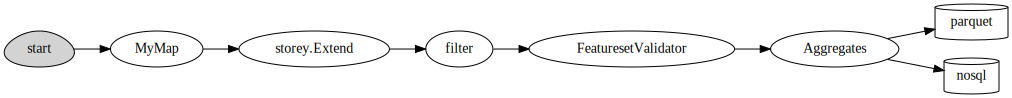

In [10]:
quotes_set.graph.to("MyMap", multiplier=3)\
                .to("storey.Extend", _fn="({'extra': event['bid'] * 77})")\
                .to("storey.Filter", "filter", _fn="(event['bid'] > 51.92)")\
                .to(FeaturesetValidator())

quotes_set.add_aggregation("ask", ["sum", "max"], "1h", "10m", name="asks1")
quotes_set.add_aggregation("ask", ["sum", "max"], "5h", "10m", name="asks5")
quotes_set.add_aggregation("bid", ["min", "max"], "1h", "10m", name="bids")

# add feature validation policy
quotes_set["bid"] = fstore.Feature(validator=MinMaxValidator(min=52, severity="info"))

# add default target definitions and plot
quotes_set.set_targets()
quotes_set.plot(rankdir="LR", with_targets=True)

**Test and show the pipeline results locally (allow to quickly develop and debug)**

In [11]:
fstore.preview(
    quotes_set,
    quotes,
    entity_columns=["ticker"],
    timestamp_key="time",
    options=fstore.InferOptions.default(),
)

info! bid value is smaller than min, key=['MSFT'] time=2021-05-23 09:04:07.013574 args={'min': 52, 'value': 51.95}
info! bid value is smaller than min, key=['MSFT'] time=2021-05-23 09:04:07.020574 args={'min': 52, 'value': 51.97}
info! bid value is smaller than min, key=['MSFT'] time=2021-05-23 09:04:07.031574 args={'min': 52, 'value': 51.99}


asks1_sum_1h  asks1_max_1h  asks5_sum_5h  asks5_max_5h  bids_min_1h  \
ticker                                                                        
GOOG          720.93        720.93        720.93        720.93       720.50   
MSFT           51.96         51.96         51.96         51.96        51.95   
MSFT          103.94         51.98        103.94         51.98        51.95   
MSFT          155.94         52.00        155.94         52.00        51.95   
GOOG         1441.86        720.93       1441.86        720.93       720.50   
AAPL           98.01         98.01         98.01         98.01        97.99   
GOOG         2162.74        720.93       2162.74        720.93       720.50   
MSFT          207.97         52.03        207.97         52.03        51.95   

        bids_max_1h                       time     bid     ask    multi  \
ticker                                                                    
GOOG         720.50 2021-05-23 09:04:07.013574  720.50  720.93  2161.50   
MSFT          51.95 2021-05-23 09:04:07.013574   51.95   51.96   155.85   
MSFT          51.97 2021-05-23 09:04:07.020574   51.97   51.98   155.91   
MSFT          51.99 2021-05-23 09:04:07.031574   51.99   52.00   155.97   
GOOG         720.50 2021-05-23 09:04:07.038574  720.50  720.93  2161.50   
AAPL          97.99 2021-05-23 09:04:07.039574   97.99   98.01   293.97   
GOOG         720.50 2021-05-23 09:04:07.062574  720.50  720.88  2161.50   
MSFT          52.01 2021-05-23 09:04:07.065574   52.01   52.03   156.03   

           extra  
ticker            
GOOG    55478.50  
MSFT     4000.15  
MSFT     4001.69  
MSFT     4003.23  
GOOG    55478.50  
AAPL     7545.23  
GOOG    55478.50  
MSFT     4004.77

In [12]:
# print the feature set object
print(quotes_set.to_yaml())

kind: FeatureSet
metadata:
  name: stock-quotes
spec:
  entities:
  - name: ticker
    value_type: str
  features:
  - name: asks1_sum_1h
    value_type: float
    aggregate: true
  - name: asks1_max_1h
    value_type: float
    aggregate: true
  - name: asks5_sum_5h
    value_type: float
    aggregate: true
  - name: asks5_max_5h
    value_type: float
    aggregate: true
  - name: bids_min_1h
    value_type: float
    aggregate: true
  - name: bids_max_1h
    value_type: float
    aggregate: true
  - name: bid
    value_type: float
    validator:
      kind: minmax
      severity: info
      min: 52
  - name: ask
    value_type: float
  - name: multi
    value_type: float
  - name: extra
    value_type: float
  partition_keys: []
  timestamp_key: time
  source:
    path: None
  targets:
  - name: parquet
    kind: parquet
  - name: nosql
    kind: nosql
  graph:
    states:
      MyMap:
        kind: task
        class_name: MyMap
        class_args:
          multiplier: 3
      stor

### Ingest data into offline and online stores
This writes to both targets (Parquet and NoSQL).

In [13]:
# save ingest data and print the FeatureSet spec
df = fstore.ingest(quotes_set, quotes)

info! bid value is smaller than min, key=['MSFT'] time=2021-05-23 09:04:07.013574 args={'min': 52, 'value': 51.95}
info! bid value is smaller than min, key=['MSFT'] time=2021-05-23 09:04:07.020574 args={'min': 52, 'value': 51.97}
info! bid value is smaller than min, key=['MSFT'] time=2021-05-23 09:04:07.031574 args={'min': 52, 'value': 51.99}
info! bid value is smaller than min, key=['MSFT'] time=2021-05-23 09:04:07.013574 args={'min': 52, 'value': 51.95}
info! bid value is smaller than min, key=['MSFT'] time=2021-05-23 09:04:07.020574 args={'min': 52, 'value': 51.97}
info! bid value is smaller than min, key=['MSFT'] time=2021-05-23 09:04:07.031574 args={'min': 52, 'value': 51.99}


## Get an offline feature vector for training
Example of combining features from 3 sources with time travel join of 3 tables with **time travel**.

Specify a set of features and request the feature vector offline result as a dataframe:

In [14]:
features = [
    "stock-quotes.multi",
    "stock-quotes.asks5_sum_5h as total_ask",
    "stock-quotes.bids_min_1h",
    "stock-quotes.bids_max_1h",
    "stocks.*",
]

vector = fstore.FeatureVector("stocks-vec", features, description="stocks demo feature vector")
vector.save()

In [15]:
resp = fstore.get_offline_features(vector, entity_rows=trades, entity_timestamp_column="time")
resp.to_dataframe()

price  quantity    multi  total_ask  bids_min_1h  bids_max_1h  \
0   51.95        75   155.97     155.94        51.95        51.99   
1   51.95       155   155.97     155.94        51.95        51.99   
2  720.77       100  2161.50    2162.74       720.50       720.50   
3  720.92       100  2161.50    2162.74       720.50       720.50   
4   98.00       100   293.97      98.01        97.99        97.99   

                    name exchange  
0  Microsoft Corporation   NASDAQ  
1  Microsoft Corporation   NASDAQ  
2           Alphabet Inc   NASDAQ  
3           Alphabet Inc   NASDAQ  
4              Apple Inc   NASDAQ

## Initialize an online feature service and use it for real-time inference

In [16]:
service = fstore.get_online_feature_service("stocks-vec")

**Request feature vector statistics, can be used for imputing or validation**

In [17]:
service.vector.get_stats_table()

count       mean     min      max          std  \
multi          8.0  925.27875  155.85  2161.50  1024.751408   
total_ask      8.0  617.91875   51.96  2162.74   784.877980   
bids_min_1h    8.0  308.41125   51.95   720.50   341.596673   
bids_max_1h    8.0  308.42625   51.95   720.50   341.583803   
name           3.0        NaN     NaN      NaN          NaN   
exchange       3.0        NaN     NaN      NaN          NaN   

                                                          hist  unique  \
multi        [[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     NaN   
total_ask    [[4, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,...     NaN   
bids_min_1h  [[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     NaN   
bids_max_1h  [[4, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...     NaN   
name                                                       NaN     3.0   
exchange                                                   NaN     1.0   

                      top  freq  
multi                 NaN   NaN  
total_ask             NaN   NaN  
bids_min_1h           NaN   NaN  
bids_max_1h           NaN   NaN  
name         Alphabet Inc   1.0  
exchange           NASDAQ   3.0

**Real-time feature vector request**

In [18]:
service.get([{"ticker": "GOOG"}, {"ticker": "MSFT"}])

[{'asks5_sum_5h': 2162.74,
  'bids_min_1h': 720.5,
  'bids_max_1h': 720.5,
  'multi': 2161.5,
  'name': 'Alphabet Inc',
  'exchange': 'NASDAQ',
  'total_ask': None},
 {'asks5_sum_5h': 207.97,
  'bids_min_1h': 51.95,
  'bids_max_1h': 52.01,
  'multi': 156.03,
  'name': 'Microsoft Corporation',
  'exchange': 'NASDAQ',
  'total_ask': None}]

In [19]:
service.get([{"ticker": "AAPL"}])

[{'asks5_sum_5h': 98.01,
  'bids_min_1h': 97.99,
  'bids_max_1h': 97.99,
  'multi': 293.97,
  'name': 'Apple Inc',
  'exchange': 'NASDAQ',
  'total_ask': None}]

In [20]:
service.close()